In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%%capture
%cd /content/
!pip install wget
!git clone https://github.com/KKMOfficial/minGPT.git
!pip3 install torch torchvision torchaudio
import wget
test_link = "https://drive.usercontent.google.com/download?id=1vY9l-110dFmbqm2AkRNllqp0MnXJaxH6&export=download&authuser=0&confirm=t&uuid=018afe8b-f360-451b-bac4-f8e714956771&at=APZUnTWO3XNqjvhgXvPBJ6GMkbxT%3A1723832924892"
wget.download(test_link, out="/content/minGPT/test_trajs.pkl")

train_link = "https://drive.usercontent.google.com/download?id=1tY_DBuZT7XhysO0I11ASW64knTcDVm1P&export=download&authuser=0&confirm=t&uuid=61dc4bed-3d20-4494-9036-f24d24cb66cd&at=APZUnTUIyzkTvbx8uyyv7xllzNDH%3A1724174332424"
wget.download(train_link, out="/content/minGPT/train_trajs.pkl")

model_link = "https://drive.usercontent.google.com/download?id=1-8eslkPzXc57WlsEOjQPG3x7ioZ4QlWd&export=download&authuser=0&confirm=t&uuid=4a85872e-3813-46fd-836b-d224f95e657f&at=AO7h07dRslCBY0nAn9xhrW938HMN%3A1724327396537"
wget.download(model_link, out="/content/minGPT/check_point.pt")

vqvae_44_200_link = "https://drive.usercontent.google.com/download?id=1-9GRdTLg-mnFmSYJtXaKPEdxzG4IF4zo&export=download&authuser=0"
wget.download(vqvae_44_200_link, out="/content/minGPT/vqvae_check_point_44_200.pt")

In [1]:
%cd minGPT
import os
import sys
import json
import pickle
import numpy as np
from math import *
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

from vqvae import VQVAE
from quantizer import get_quantizer

e:\MoCAP\MCDH\minGPT\minGPT


In [2]:
class TrajectoryDataset(Dataset):
    """
    generate sequences of consecutive state-actions in the humanoid environment
    """
    @staticmethod
    def get_default_config(sequence_length=5, traj_addr=None):
        C = CN()
        C.STATE_DIM  = 24
        C.ACTION_DIM = 56
        C.SEQ_LEN    = sequence_length # 5 (24+56) = 400 tokens
        C.PRECISION  = 1e-2    # 200 tokens in total [-1,1,200]
        C.VOCAB_SIZE = 200 + 200 + 1
        C.StAc_SIZE = 24 + 56
        if not traj_addr is None : C.TRAJ_ADDR=traj_addr
        return C

    def __init__(self, config, vqvae):
        self.config    = config
        self.traj_list = None
        self.buffer    = []
        self.accum_idx = [ 0 ]
        self.state_vqvae = vqvae
        self.q = 1/self.config.PRECISION
        self.act_encoder = lambda x: (self.q*x+3*self.q)//1
        self.act_decoder = lambda z: (z-3*self.q)/self.q
        # decoder related information
        self.decoder_state_idxs        = None
        self.decoder_action_idxs       = None
        self.decoder_starts_with_state = None
        self.decoder_ends_with_state   = None
        prep_trajs     = []
        # load trajectory dataset
        with open(self.config.TRAJ_ADDR,"rb") as f: self.traj_list = pickle.load(f)
        # preprocess trajectories : encode states into latent space
        processed_trajectories = []
        for trajectory in self.traj_list :
            traj_states  = torch.tensor(np.array([x for i,x in enumerate(trajectory) if i%2==0]))
            trans_states = self.state_vqvae(traj_states)[2]
            traj_actions = torch.tensor(np.array([x for i,x in enumerate(trajectory) if i%2==1]))
            trans_actions= self.act_encoder(traj_actions)
            processed_trajectories += [ [trans_actions[i//2] if i%2==1 else trans_states[i//2].reshape(1,-1) for i in range(len(trajectory))] ]
        self.traj_list = processed_trajectories
        # maximum available sample trajectory in each agent trajectory
        for trajectory in self.traj_list :
            if len(trajectory)//2<self.config.SEQ_LEN: continue
            self.buffer     += [ len(trajectory)//2-self.config.SEQ_LEN+1 ]
            self.accum_idx  += [ self.accum_idx[-1] + self.buffer[-1] ]
            # preprocess raw trajectory lists
            prep_trajs += [ torch.concatenate(trajectory, axis=1)[0] ]
        # we choose random trajectories then form them when they are needed during the training
        # finding indeces are base on the accumulative index array
        self.accum_idx = np.array(self.accum_idx)[1:]
        # update trajectory list
        self.traj_list = prep_trajs
        self.state_action = self.config.STATE_DIM + self.config.ACTION_DIM


    def initialize_decoder(self, valid_trajectory):
        # will set the state and action index position so that decoder behave correctly
        self.decoder_state_idxs, self.decoder_action_idxs = torch.argwhere(valid_trajectory<200), torch.argwhere(valid_trajectory>=200)
        self.decoder_starts_with_state = self.decoder_state_idxs[0]<self.decoder_action_idxs[0]
        self.decoder_ends_with_state   = self.decoder_state_idxs[-1]>self.decoder_action_idxs[-1]

    def decode_trajectory(self, tokenized_trajectory):
        # will get an input of tokens and decode it!
        # don't forget to initialize decoder before using it!
        # if given trajectory IS valid, then there must be not problem!
        # valid trajectory : it's length is multiple of 100 with contiguous states[44] and actions[56] tokens
        decoded_states = self.state_vqvae.decode_indices(torch.clip(tokenized_trajectory[self.decoder_state_idxs].reshape((-1,self.config.STATE_DIM)), min=0, max=199))
        decoded_actions= self.act_decoder(torch.clip(tokenized_trajectory[self.decoder_action_idxs],min=200, max=400).reshape(-1,1,self.config.ACTION_DIM))
        
        num_states, num_actions = decoded_states.shape[0], decoded_actions.shape[0]
        final_result = \
            torch.concatenate((decoded_states[:-1 if self.decoder_ends_with_state else num_states],decoded_actions[:num_actions if self.decoder_ends_with_state else -1]), dim=2) if self.decoder_starts_with_state else\
            torch.concatenate((decoded_actions[:num_actions if self.decoder_ends_with_state else -1],decoded_states[:-1 if self.decoder_ends_with_state else num_states]), dim=2)
        final_result = \
            torch.concatenate(( final_result.reshape((final_result.shape[1],-1)),
                decoded_states[-1] if self.decoder_ends_with_state else decoded_actions[-1]
            ), dim=-1)
        return final_result

    def get_vocab_size(self):
        # based on range and precision 1d tokens are provided, the semantics for each of these
        # will be learned in the latent space given number of channels
        return self.config.VOCAB_SIZE

    def get_block_size(self):
        # a simple shifted SEQ_LEN block of state actions
        return self.config.SEQ_LEN * self.config.StAc_SIZE

    def __len__(self):
        # total number of the data inside the dataset!
        return self.accum_idx[-1]

    def __getitem__(self, idx):
        # form sample
        traj_index  = np.where(self.accum_idx > idx)[0][0]
        slice_index = idx - (self.accum_idx[traj_index-1] if traj_index>0 else 0)
        # form input domain element
        trajectory  = self.traj_list[traj_index][slice_index*self.state_action:1+(slice_index+self.config.SEQ_LEN)*self.state_action]
        x = torch.tensor(trajectory[0:self.config.SEQ_LEN*(self.config.STATE_DIM+self.config.ACTION_DIM)], dtype=torch.long)
        # form output domain element
        y = torch.tensor(trajectory[1:1+self.config.SEQ_LEN*(self.config.STATE_DIM+self.config.ACTION_DIM)], dtype=torch.long)
        return x, y

In [3]:
def get_config():

    C = CN()

    # device
    C.device = 'cuda'

    # system
    C.system = CN()
    C.system.seed = 3407
    # C.system.work_dir = '/content/drive/MyDrive/out/dynamic'
    C.system.work_dir = 'E:/MoCAP/MCDH/minGPT/dynamic'

    # data
    C.data = TrajectoryDataset.get_default_config()
    C.data.TRAJ_ADDR = 'E:/MoCAP/MCDH/minGPT/valid_trajs.pkl'

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-nano'

    # trainer
    C.trainer = Trainer.get_default_config()
    C.trainer.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster


    return C

In [ ]:
# clear cuda device memory
from numba import cuda

cuda.select_device(0) # choosing second GPU
cuda.close()

In [5]:
# truncate datasets if needed
with open("/content/minGPT/test_trajs.pkl","rb") as f:
  x = pickle.load(f)

with open("/content/minGPT/test_trajs_overfit.pkl","wb") as f:
  pickle.dump(x[1:3], f)

[VQ-VAE Loading] : Successful.
[Train Dataset Size] : 9999
[Test Dataset Size] : 9499
[Validation Dataset Size] : 9999
device: cuda
system:
    seed: 3407
    work_dir: E:/MoCAP/MCDH/minGPT/dynamic
data:
    STATE_DIM: 24
    ACTION_DIM: 56
    SEQ_LEN: 5
    PRECISION: 0.01
    VOCAB_SIZE: 401
    StAc_SIZE: 80
    TRAJ_ADDR: E:/MoCAP/MCDH/minGPT/valid_trajs.pkl
model:
    model_type: None
    n_layer: 2
    n_head: 2
    n_embd: 48
    vocab_size: 401
    block_size: 800
    embd_pdrop: 0.1
    resid_pdrop: 0.1
    attn_pdrop: 0.1
trainer:
    device: cpu
    num_workers: 4
    max_iters: None
    batch_size: 2
    learning_rate: 0.0005
    betas: (0.9, 0.95)
    weight_decay: 0.1
    grad_norm_clip: 1.0

number of parameters: 0.11M
running on device cpu


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13716\1091214857.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(trajectory[0:self.config.SEQ_LEN*(self.config.STATE_DIM+self.config.ACTION_DIM)], dtype=torch.long)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_13716\1091214857.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(trajectory[1:1+self.config.SEQ_LEN*(self.config.STATE_DIM+self.config.ACTION_DIM)], dtype=torch.long)


iter_dt 0.00ms; iter 0: train loss 5.98413
itr 0, validation loss : 5.984198760986328


100%|██████████| 664/664 [00:16<00:00, 40.40it/s] 


saving model
iter_dt 97.94ms; iter 10: train loss 5.82800
itr 10, validation loss : 5.8291853904724125
iter_dt 83.95ms; iter 20: train loss 5.70890
itr 20, validation loss : 5.711903762817383


KeyboardInterrupt: 

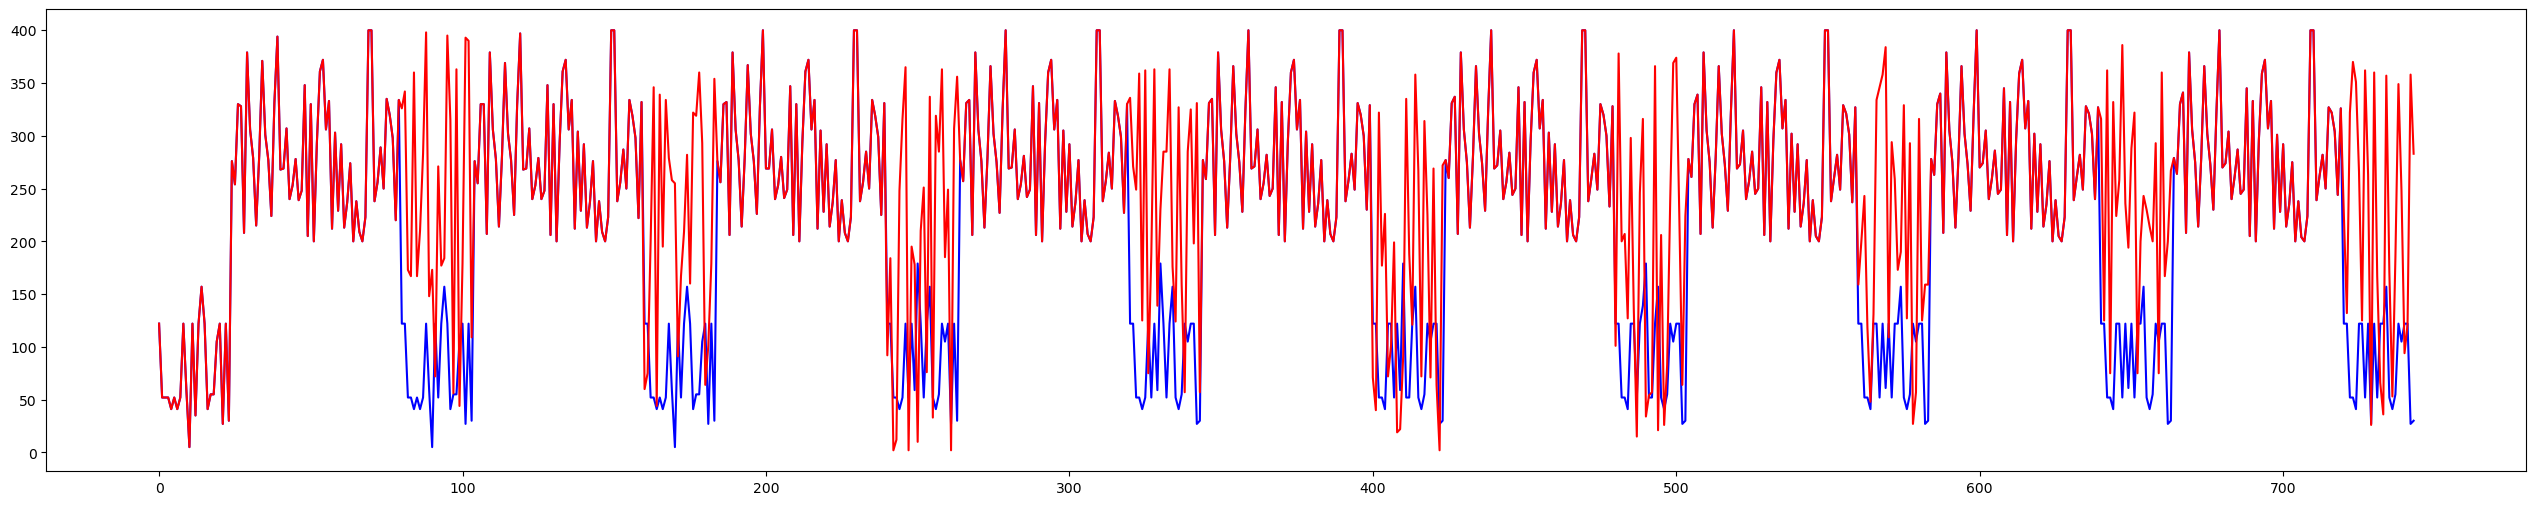

In [4]:
# get default config and overrides from the command line, if any
config = get_config()
config.trainer.device='cpu'
config.trainer.batch_size = 2
config.model.model_type = None
config.model.n_layer = 2
config.model.n_head = 2
config.model.n_embd = 48
# config.trainer.num_workers = 0 # windows only
# config.merge_from_args(sys.argv[1:])
setup_logging(config)
set_seed(config.system.seed)

# load the VQ-VAE model
vqvae_model = VQVAE(input_dim=1, hidden_dim=44, num_embeddings=200, embedding_dim=44)
try:
    vqvae_model.load_state_dict(torch.load("E:/MoCAP/MCDH/minGPT/vqvae_check_point_44_200.pt"))
    print('[VQ-VAE Loading] : Successful.')
except Exception as e:
    print(f'[VQ-VAE Loading] : Failed, {e}')

# construct the training dataset
train_actions = 5
test_actions  = 10
test_dataset  = TrajectoryDataset(TrajectoryDataset.get_default_config(test_actions,"E:/MoCAP/MCDH/minGPT/test_trajs.pkl"),vqvae_model)
# valid_dataset = TrajectoryDataset(TrajectoryDataset.get_default_config(train_actions,"E:/MoCAP/MCDH/minGPT/test_trajs_overfit.pkl"),vqvae_model)
valid_dataset  = TrajectoryDataset(TrajectoryDataset.get_default_config(train_actions,"E:/MoCAP/MCDH/minGPT/test_trajs.pkl"),vqvae_model)
# train_dataset = TrajectoryDataset(TrajectoryDataset.get_default_config(train_actions,"/content/minGPT/train_trajs.pkl"),vqvae_model)
train_dataset  = TrajectoryDataset(TrajectoryDataset.get_default_config(train_actions,"E:/MoCAP/MCDH/minGPT/test_trajs.pkl"),vqvae_model)

# construct the model
config.model.vocab_size = test_dataset.get_vocab_size()
config.model.block_size = test_dataset.get_block_size()
print(f'[Train Dataset Size] : {train_dataset.__len__()}')
print(f'[Test Dataset Size] : {test_dataset.__len__()}')
print(f'[Validation Dataset Size] : {valid_dataset.__len__()}')
print(config)

# load model's weights using checkpoint
model = GPT(config.model)
# model.load_state_dict(torch.load("E:/MoCAP/MCDH/minGPT/check_point.pt"))
# print(f'[LOG] : using pretrained model.')

# construct the trainer object
trainer = Trainer(config.trainer, model, train_dataset, valid_dataset)

# initialize test dataset trajectory decoder
test_dataset.initialize_decoder(test_dataset.__getitem__(random.randint(0,test_dataset.__len__()))[0][:-56])

# iteration callback
def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        validation_loss = trainer.validate(iters=10)
        trainer.train_loss_history += [[trainer.loss.item(),validation_loss]]
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        print(f"itr {trainer.iter_num}, validation loss : {validation_loss}")

    if trainer.iter_num % 500 == 0:
        # evaluate both the train and test score
        model.eval()
        with torch.no_grad():
            # sample from the model...
            random_traj  = test_dataset.__getitem__(random.randint(0,test_dataset.__len__()))
            state_action, num_actions = config.data.STATE_DIM+config.data.ACTION_DIM, test_actions-1
            traj_action  = [random_traj[0][i*state_action+config.data.STATE_DIM:(i+1)*state_action] for i in range(num_actions)]
            input_traj = torch.concatenate([random_traj[0][:config.data.STATE_DIM]]+traj_action, dim=0)[None,...].to(trainer.device)
            y_tokenized = model.generate(input_traj, temperature=1.0, do_sample=False, top_k=10, n_actions=num_actions)[0]
            # will use the decoded version inside the predictive sampling controller
            y = test_dataset.decode_trajectory(y_tokenized)
            # draw the result plot
            fig, ax = plt.subplots(figsize=(32, 6))
            label = random_traj[0][:(num_actions)*state_action+config.data.STATE_DIM]
            ax.plot(list(range(label.shape[0])), label, color='blue', label='ground truth')
            ax.plot(list(range(y_tokenized.shape[0])), y_tokenized.detach().cpu().numpy(), color='red', label='generated')
            plt.plot()

        # save the latest model
        print("saving model")
        ckpt_path = os.path.join(config.system.work_dir, "model.pt")
        torch.save(model.state_dict(), ckpt_path)
        with open(os.path.join(config.system.work_dir,"train_history.pkl"),"wb") as f:
            pickle.dump(trainer.train_loss_history, f)
        # revert model to training mode
        model.train()

trainer.set_callback('on_batch_end', batch_end_callback)

# run the optimization
trainer.run()